# PHASE 1 Multiple Monolingual Classification
This dataset contains blog posts labeled by language and by category.

In [3]:
import pandas as pd
import numpy as np
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


#### Import data in a dataframe.

In [103]:
dataset = pd.read_csv('data/dataset.csv', sep='\t', header=None).applymap(str)
#Get the labels for languages
languages = dataset[dataset.columns[0]].unique()
#Show the labels for categories
categories = dataset[dataset.columns[1]].unique()
#Rename Dataset Columns
dataset.columns = ["Language","Label","Text"]
#Encode the labels of the dataset
dataset.Label.unique()

# from sklearn.preprocessing import LabelEncoder
# label_encoder = LabelEncoder()
# dataset["Label"] = label_encoder.fit_transform(dataset["Label"])

array(['advertising', 'agriculture', 'animation', 'arts_and_crafts',
       'entertainment', 'astrology', 'vehicles', 'games',
       'books_and_literature', 'business', 'gambling', 'jobs', 'clothing',
       'comic_books', 'dating', 'education', 'adult', 'food', 'health',
       'hobbies_and_interests', 'humor', 'illegal_content', 'investing',
       'jewelry', 'logistics', 'marketing', 'movies', 'music', 'hacking',
       'media', 'finance', 'pets', 'politics', 'religion',
       'sci_fi_and_fantasy', 'science', 'shopping', 'society', 'sports',
       'tech', 'teens', 'television', 'travel', 'under_construction',
       'weather'], dtype=object)

#### create a dataset for each language


In [104]:
languagesData=[]
loc = 0
for i in languages:
    name = languages[loc]+"Data" 
    globals()[name] = pd.DataFrame( dataset[dataset.Language == i])
    loc += 1
                        

#### Prepare the English dataset to be trained

In [6]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Some Langugaes failed, because there are so categories that has only 1 or 2 article, which leaded into a problem because the training dataset, testing and the validation dataset has different number of categories so this function is used to remove this row.

In [7]:
def Remove3Row(inputD):
    mydataset = inputD
    value_counts = mydataset['Label'].value_counts()

    # Select the values where the count is less than 3
    to_remove = value_counts[value_counts < 3].index

    # Keep rows where the city column is not in to_remove
    mydataset = mydataset[~mydataset.Label.isin(to_remove)]
    return mydataset


In [19]:
from keras.layers import GRU,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

def myfunc(myDataset,shape,lang):
    myDataset = Remove3Row(myDataset)

    print(myDataset.head())
    X = myDataset.Text
    Y = myDataset.Label

    encoder = LabelEncoder()
    encoder.fit(Y)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1,stratify = Y)

    Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=1,stratify = Ytrain)



    Ytrain = encoder.transform(Ytrain)
    Ytest = encoder.transform(Ytest)
    Yval = encoder.transform(Yval)

    Ytrain = np_utils.to_categorical(Ytrain)
    Ytest = np_utils.to_categorical(Ytest)
    Yval = np_utils.to_categorical(Yval)


    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(Xtrain)

    Xtrain = tokenizer.texts_to_sequences(Xtrain)
    Xtest = tokenizer.texts_to_sequences(Xtest)
    Xval = tokenizer.texts_to_sequences(Xval)
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

    maxlen = 100

    Xtrain = pad_sequences(Xtrain, padding='post', maxlen=maxlen)
    Xtest = pad_sequences(Xtest, padding='post', maxlen=maxlen)
    Xval = pad_sequences(Xval, padding='post', maxlen=maxlen)


    from keras.models import Sequential
    from keras import layers

    embedding_dim = 50

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))


    model.add(GRU(256))
    model.add(Dropout(0.1))
    model.add(layers.Dense(shape, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(Xtrain, Ytrain,
                        epochs=10,
                        verbose=True,
                        validation_data=(Xval, Yval))
    f= open("report.csv","a")
    loss, accuracy = model.evaluate(Xtrain, Ytrain, verbose=True)
    print("Training Accuracy: {:.4f}".format(accuracy))
    f.write(lang+",{:.4f}".format(accuracy))

    loss, accuracy = model.evaluate(Xval, Yval, verbose=True)
   
    print("Validation Accuracy:  {:.4f}".format(accuracy))
    f.write(",{:.4f} \n".format(accuracy))
    f.close()
    plot_history(history)
    Ypred = model.predict(Xtest)
    from sklearn.metrics import confusion_matrix, classification_report

    matrix = confusion_matrix(Ytest.argmax(axis=1), Ypred.argmax(axis=1))
    classification_Report = classification_report(Ytest.argmax(axis=1), Ypred.argmax(axis=1), output_dict=True)
    df = pd.DataFrame(classification_Report).transpose()
    df.to_csv(lang+"ClassificationReport.csv")



#### Helping function for plotting the results

      Language        Label                                               Text
20169   french  advertising  Home / GEEK / Le gouvernement américain interd...
20170   french  advertising  By OlivierLa puce la plus intéressante du lot ...
20171   french  advertising  Home / PEOPLE / Mélanie Da Cruz maman : Anthon...
20172   french  advertising  Arabie saoudite : plus de deux millions de fid...
20173   french  advertising  21 août 2018 à 10h16 | Par El Mehdi BerradaMoh...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           3249550   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               235776    
_________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


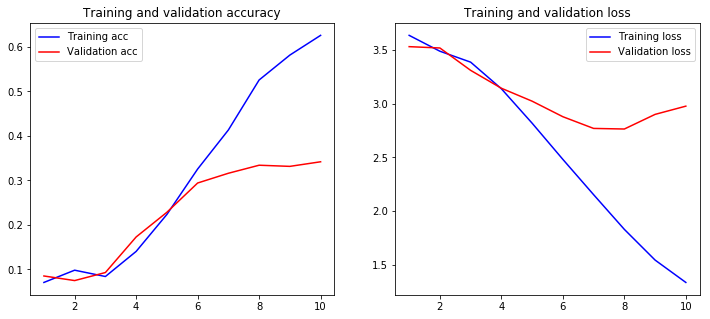

In [7]:
myfunc(frenchData,40,"french")

      Language        Label                                               Text
55590  spanish  advertising  CIUDAD DE MÉXICO (apro).- Miguel Ángel Marín, ...
55591  spanish  advertising  Sigue la clausura de los Juegos Centroamerican...
55592  spanish  advertising  CIUDAD DE MÉXICO (apro).- Gerardo Axel “N”, ub...
55593  spanish  advertising  CIUDAD DE MÉXICO (apro).- En 2009, el movimien...
55594  spanish  advertising  CIUDAD DE MÉXICO (apro).- El Instituto de Veri...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           3635150   
_________________________________________________________________
gru_2 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


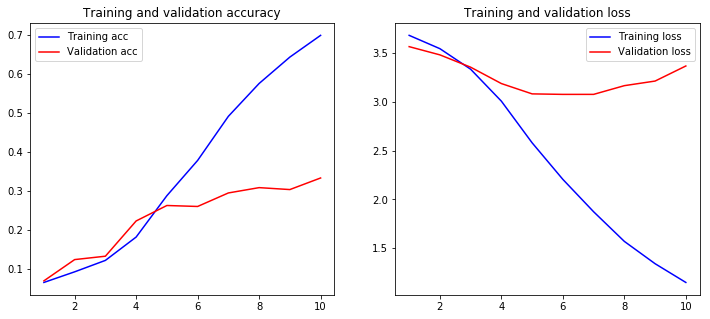

In [8]:
myfunc(spanishData,42,"spanish")

     Language          Label  \
5091   arabic  entertainment   
5092   arabic  entertainment   
5093   arabic  entertainment   
5094   arabic  entertainment   
5095   arabic  entertainment   

                                                   Text  
5091  تشاهدونا اليوم علي قناة ON Sport 2 مباريات الد...  
5092  سِنغري يسأل هواسا عن عضوها المفضل من Big Bang!...  
5093  يعنى ضاضا كان بيحترم الدولة ودلوقتى مبقاش يحتر...  
5094  بارك بوم تحيي معجبيها كفنانة من وكالة D Nation...  
5095  تشكيل فريقي نجوم إف سي والمقاولون العرب لمواجه...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           2902250   
_________________________________________________________________
gru_3 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0       

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


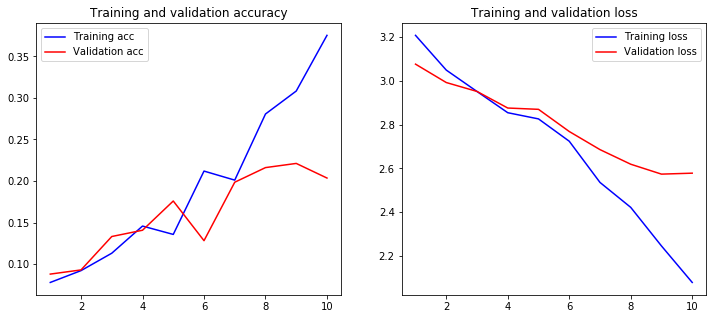

In [9]:
myfunc(arabicData,27, "arabic")

  Language        Label                                               Text
0  english  advertising  Exclusive: U.S. government seeks Facebook help...
1  english  advertising  Trump asks SEC to mull half-year corporate fil...
2  english  advertising  Wall St. up on trade hopes, S&P equals longest...
3  english  advertising  Asian shares hit one-year low on Turkey, China...
4  english  advertising  Asian stocks weaken as Turkey worries weigh, d...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 50)           3513400   
_________________________________________________________________
gru_4 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)       

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


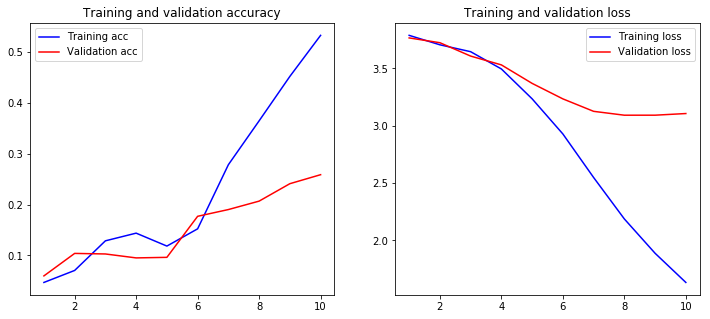

In [10]:
myfunc(englishData,45,"english")

Trying Another model to increace accuracy

       Language          Label  \
7083  bulgarian  entertainment   
7084  bulgarian  entertainment   
7085  bulgarian  entertainment   
7086  bulgarian  entertainment   
7087  bulgarian  entertainment   

                                                   Text  
7083  По-скъпа "Гражданска"... Справедливо ли ще е? ...  
7084  Абонамент по имейл за публикациите в Alex Deve...  
7085  Промо код PAKTA или PAKTA-TECH за 10%(всичко) ...  
7086  Заклещени в шахта! Пожарникари спасиха четири ...  
7087  Къде и за колко: Най-търсените имоти в големит...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           1293950   
_________________________________________________________________
gru_5 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


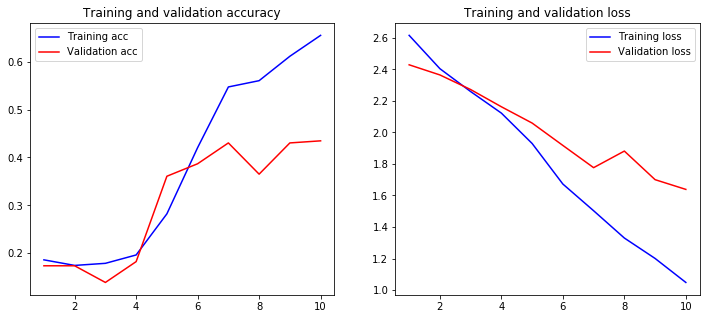

In [11]:
myfunc(bulgarianData,15,"bulgarian") 

     Language          Label  \
8236  chinese  entertainment   
8237  chinese  entertainment   
8238  chinese  entertainment   
8239  chinese  entertainment   
8240  chinese  entertainment   

                                                   Text  
8236  飞鸟企业云精心为您打造企业云存储产品，为您提供了安全、稳定、高效的数据传输、备份、管理服务，...  
8237  身师快速设计手稿，草图，1.0版本包括Old school、Newschool、新传统、日式...  
8238  深驾是以自驾游为核心的互联网旅行品牌，定位于追求旅行品质的旅行者，打造量身定制、深度纯玩的旅...  
8239  服务大众！惠及大众！畅充科技是“新便民”生活和出行理念的开创者和领导者，本着便民、惠民为本的...  
8240  iPhone Screenshots Description 人人小柜app是一款分消费者，...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           647750    
_________________________________________________________________
gru_6 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0       

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


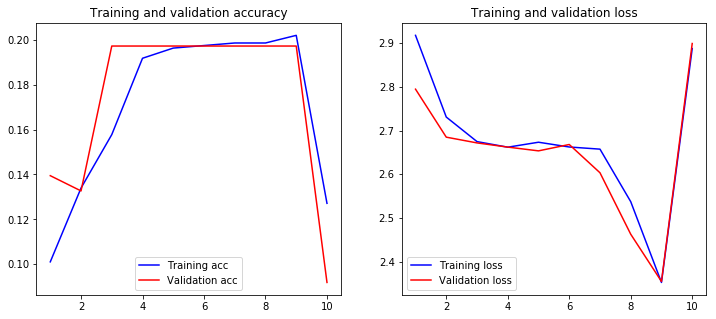

In [12]:
myfunc(chineseData,20,"chinese")

      Language        Label                                               Text
9709  croatian  advertising  Preminula žena koja je pronađena bez svesti na...
9710  croatian  advertising  Folkloraši iz zemlje i regiona nastupaju u Med...
9711  croatian  advertising  Vranjanac poginuo dok je prelazio prugu by Adm...
9712  croatian  advertising  Droga i devize u donjem vešu i salveti by Admi...
9713  croatian  advertising  Urednici “Jugpresa” pretili “surovim progonom”...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 50)           2273500   
_________________________________________________________________
gru_7 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


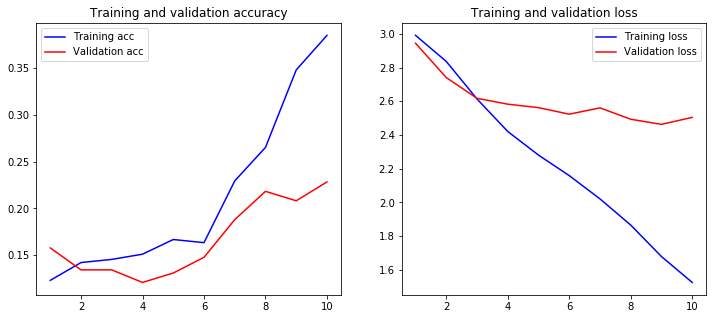

In [13]:
myfunc(croatianData,21,"croatian")

      Language          Label  \
11211    czech  entertainment   
11212    czech  entertainment   
11213    czech  entertainment   
11214    czech  entertainment   
11215    czech  entertainment   

                                                    Text  
11211  00:06:00 Přišli Bójové ze Slezska do Čech ve 4...  
11212  00:00:05 Česká televize uvádí francouzský doku...  
11213  00:09:53 S tím, že tam mají obrovské množství ...  
11214  00:43:44 Co je? Antoníne! Co ti je?00:43:50 An...  
11215  Přidal: Martin | Srpen 14, 2018Ben Aaronovitch...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 50)           3269750   
_________________________________________________________________
gru_8 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


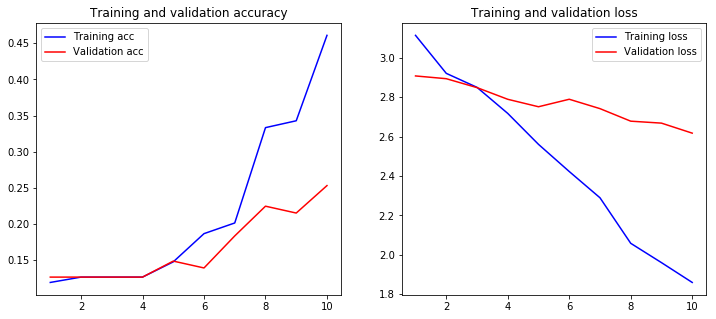

In [14]:
myfunc(czechData,25,"czech")

      Language        Label                                               Text
12796   danish  advertising  Forside » Nyheder » H+H øger indtjeninge.. « 1...
12797   danish  advertising  04 sep: Nordea siger farvel til chef for Perso...
12798   danish  advertising  16 aug: WDH/Carnegie: Anbefalingen sænkes til ...
12799   danish  advertising  Forside » Nyheder » Vestas: Igen højere .. « 1...
12800   danish  advertising  23 aug: Ambu fortsætter i vækstsporet og opjus...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 50)           2039000   
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               235776    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


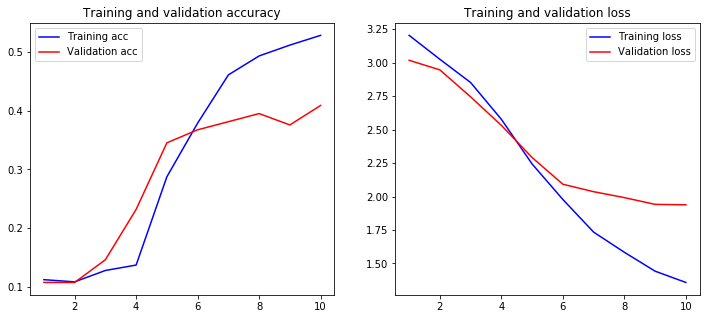

In [15]:
myfunc(danishData,29,"danish")


      Language        Label                                               Text
14610    dutch  advertising  Dochtertje (4) gooit smartphone vader in zee D...
14611    dutch  advertising  Van der Weijden had een zware nacht, maar zwem...
14612    dutch  advertising  Dit betekent het als je voor de wekker wakker ...
14613    dutch  advertising  In het nieuws Lili en Howick smeken Rutte, Har...
14614    dutch  advertising  Publieke omroep krijgt toch nog extra geld De ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 50)           2933150   
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


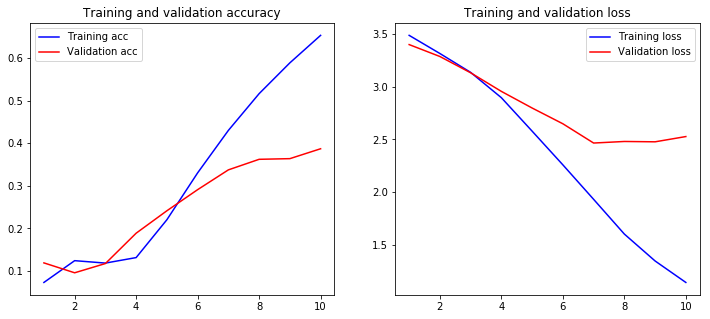

In [16]:
myfunc(dutchData,35,"dutch")

      Language        Label                                               Text
24042   german  advertising  14.08.2018 - 14:19 Ein Ass auf dem Basketballp...
24043   german  advertising  14.08.2018 - 12:40 Kollaboration der Superlati...
24044   german  advertising  13.08.2018 - 15:49 Unglaublicher WeltrekordAll...
24045   german  advertising  FacebookHachenburg (ots) – Am Montagabend, 20....
24046   german  advertising  FacebookPfalzfeld (ots) – Am frühen Dienstagmo...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 50)           4354550   
_________________________________________________________________
gru_11 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


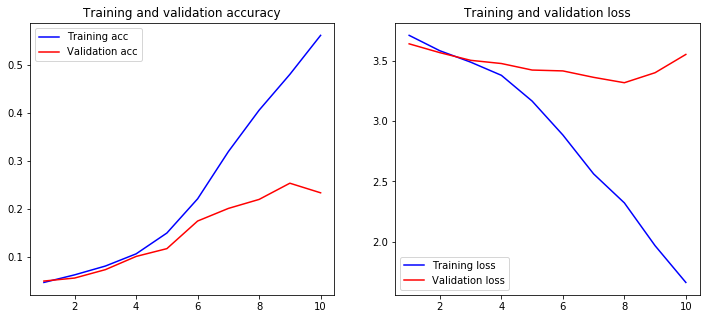

In [17]:
myfunc(germanData,44,"german")

      Language        Label                                               Text
28042    greek  advertising  Χάος στην Σουηδία από οργανωμένες επιθέσεις κα...
28043    greek  advertising  Καταρρέει η τουρκική λίρα… 30/08/2018, 10:22 Μ...
28044    greek  advertising  Θεσσαλονίκη: Διαμαρτυρία για τους πλειστηριασμ...
28045    greek  advertising  Ξεσήκωσε το νησί γνωστό μοντέλο με στρινγκ μαγ...
28046    greek  advertising  Search for: Search Χρησιμοποιούμε cookies για ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 50)           2955200   
_________________________________________________________________
gru_12 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


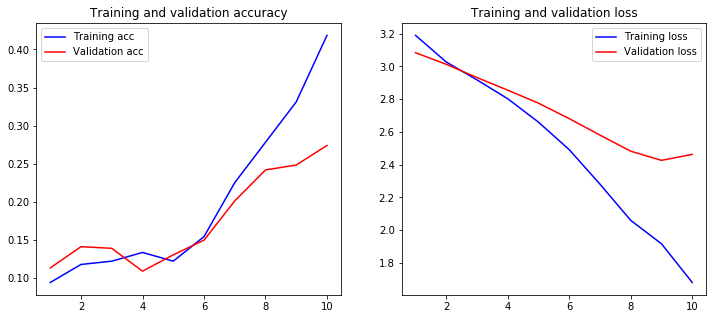

In [18]:
myfunc(greekData,26,"greek")

      Language          Label  \
30378   hebrew  entertainment   
30379   hebrew  entertainment   
30380   hebrew  entertainment   
30381   hebrew  entertainment   
30382   hebrew  entertainment   

                                                    Text  
30378  עידו שחם • 18 באוגוסט 2018 איתי איתי זבולון או...  
30379  עידו שחם • 20 באוגוסט 2018שעה באולפן עם להקת ה...  
30380  Home / DIY VIDEOS / עשה/י זאת בעצמך: DIY מחברו...  
30381  עידו שחם • 18 245: מלאכותישעה של מוזיקה אקלקטי...  
30382  ניצן אגסי • 1 בספטמבר 2018 איה זהבי פייגלין בר...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 50)           2371350   
_________________________________________________________________
gru_13 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_13 (Dropout)         (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


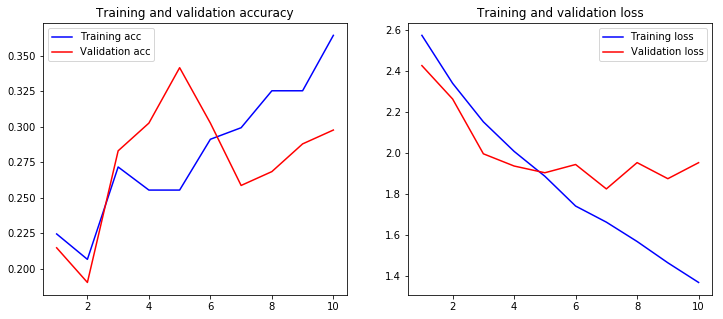

In [19]:
myfunc(hebrewData,15,"hebrew")

      Language        Label                                               Text
34286  italian  advertising  agosto 16, 2018 Gli informati SCONTI-COUPON 0C...
34287  italian  advertising  agosto 27, 2018 Gli informati SCONTI-COUPON 0C...
34288  italian  advertising  settembre 3, 2018 Gli informati SCONTI-COUPON ...
34289  italian  advertising  settembre 7, 2018 Gli informati SCONTI-COUPON ...
34290  italian  advertising   SCONTI-COUPON 0Prova a vincere un Samsung Gal...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 50)           3502950   
_________________________________________________________________
gru_14 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


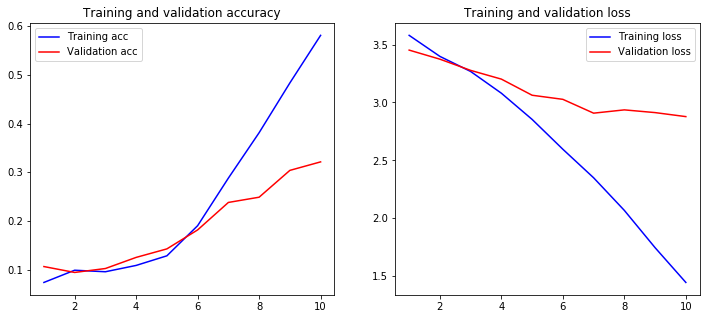

In [20]:
myfunc(italianData,39,"italian")

      Language          Label  \
40647   korean  entertainment   
40648   korean  entertainment   
40649   korean  entertainment   
40650   korean  entertainment   
40651   korean  entertainment   

                                                    Text  
40647  - 오늘 다녀간 맛집을 기록하고, 추억을 보관하세요.- 가보고 싶은 맛집을 기록해두...  
40648  Ai-Pay 에서는 2가지 서비스를 제공 하고 있습니다.1. 쇼핑몰 연동형 결제 모...  
40649  따뜻한 마음을 담고 나눌 캐릭터의 힘, 캐릭터 마케팅 벌이는 이랜드의 새 캐릭터 러...  
40650  Home / DIY VIDEOS / DIY 여성 2 layer pleats band...  
40651  아마존 파이어 HD 8(Amazon Fire HD)... 아마존 알렉사 핸즈 프리를...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 100, 50)           2847350   
_________________________________________________________________
gru_15 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


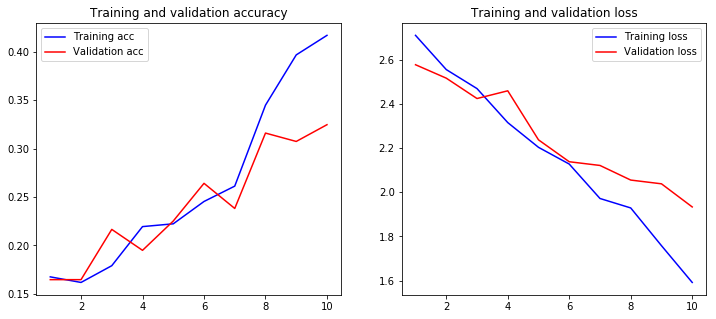

In [21]:
myfunc(koreanData,16,"korean")

      Language        Label                                               Text
43077   polish  advertising  17 lutego 2011, na swoim blogu na portalu Salo...
43078   polish  advertising  – serwis gwarancyjny i pogwarancyjny PARAMETRY...
43079   polish  advertising  relacje społeczneJako że jednym z założeń, któ...
43080   polish  advertising  Huna w Starym Testamencie, Materiały Zebrane, ...
43081   polish  advertising  Twittericon Masz konto na Twitterze? Zacznij n...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 50)           3052300   
_________________________________________________________________
gru_16 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


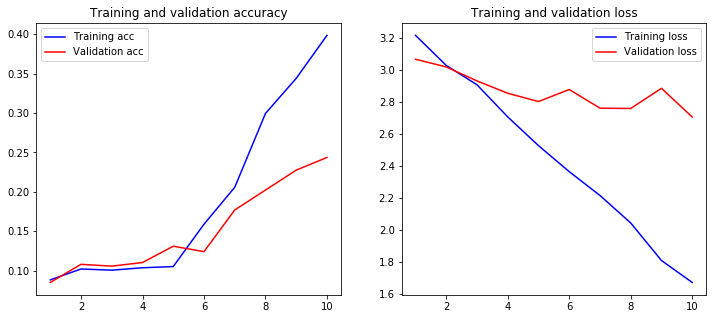

In [22]:
myfunc(polishData,27,"polish")

       Language          Label  \
48630  romanian    advertising   
48631  romanian    advertising   
48632  romanian    advertising   
48633  romanian  entertainment   
48634  romanian  entertainment   

                                                    Text  
48630  TweetEla Crăciun, prezentatoare TV și autoarea...  
48631  N-am mai scris de mult timp un articol dedicat...  
48632  Am urmarit ca de obicei evenimentele din Piata...  
48633  14 august 2018am și eu o întrebare… ăstora cin...  
48634   Melania Trump, Donald Trump, Autor Gabriela B...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 100, 50)           2949900   
_________________________________________________________________
gru_17 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)     

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


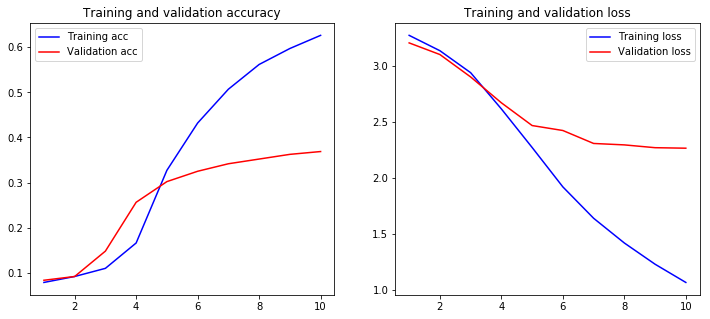

In [23]:
myfunc(romanianData,29,"romanian")

      Language        Label                                               Text
51030  russian  advertising  Складская программа и продажи на Amazon ; Прод...
51031  russian  advertising  Сколько стоит простой сайт? 11 сентября 2018 Б...
51032  russian  advertising  20 Августа 2018 в 15:06 228 Новостные медиа и ...
51033  russian  advertising  Дарья Кармадонова 24.08.2018 в 15:00 О роли ин...
51034  russian  advertising  Четвёртый SEO-марафон от 9SEO . Для тех, кто н...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 50)           4236950   
_________________________________________________________________
gru_18 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


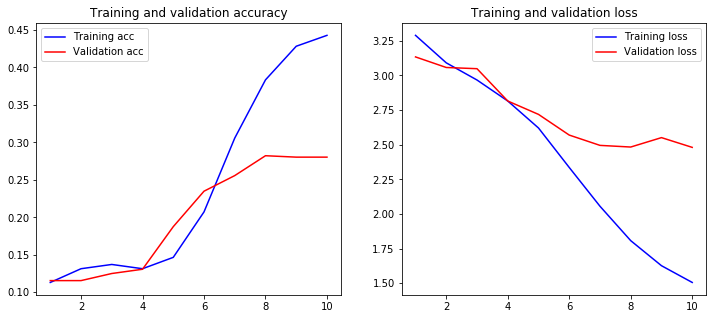

In [24]:
myfunc(russianData,29,"russian")

      Language        Label                                               Text
53674  serbian  advertising  Prokupački budžet – za vlast u suficitu, za op...
53675  serbian  advertising  Međunarodna izložba pasa u Leskovcu by Admin /...
53676  serbian  advertising  Železničar ispao iz EHF kupa, Kaerjeng prejak ...
53677  serbian  advertising  Odbornici većine u Blacu: Iza hapšenja predsed...
53678  serbian  advertising  Promene na čelu svrljiške Skupštine VestiNakon...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 100, 50)           2256700   
_________________________________________________________________
gru_19 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


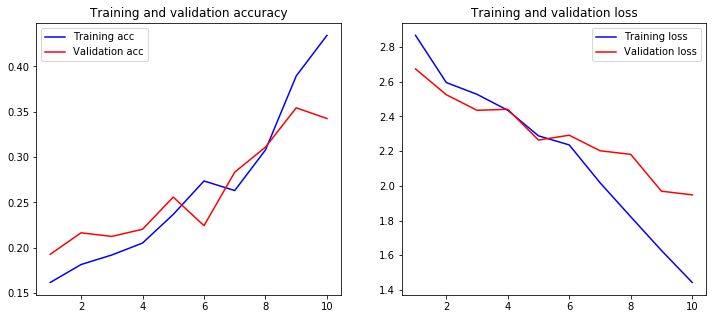

In [25]:
myfunc(serbianData,19,"serbian")

        Language          Label  \
54943  slovenian  entertainment   
54944  slovenian  entertainment   
54945  slovenian  entertainment   
54946  slovenian  entertainment   
54947  slovenian  entertainment   

                                                    Text  
54943  Slovenka iz Züricha: zakaj švicarsko zdravstvo...  
54944  Kako se pravilno lotiti nakupovanja šolskih po...  
54945  Otroci morajo biti popoldne doma, da se umirij...  
54946  Potrebujete popolno preobrazbo? Vsebino omogoč...  
54947  Kdo je kriv, da je sodišče moralo odmrzniti pr...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 50)           1442200   
_________________________________________________________________
gru_20 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


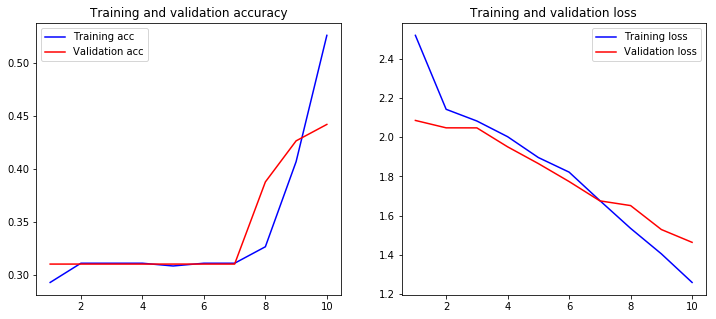

In [26]:
myfunc(slovenianData,13,"slovenian")

      Language        Label                                               Text
61964  turkish  advertising  Bebeğinizin İsmini Harland Koyar Mıydınız? KFC...
61965  turkish  advertising  4Kahve lekesiyle tamamlanan kartpostallar , bu...
61966  turkish  advertising  Cannes Lions Gürsu’nun Elektrik Trafo Dolaplar...
61967  turkish  advertising  Cannes Lions Chef’s Table’da Bir Türk Şef: Mus...
61968  turkish  advertising  Beren Saat Greenpeace için orangutanların sesi...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 100, 50)           3323200   
_________________________________________________________________
gru_21 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
________________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


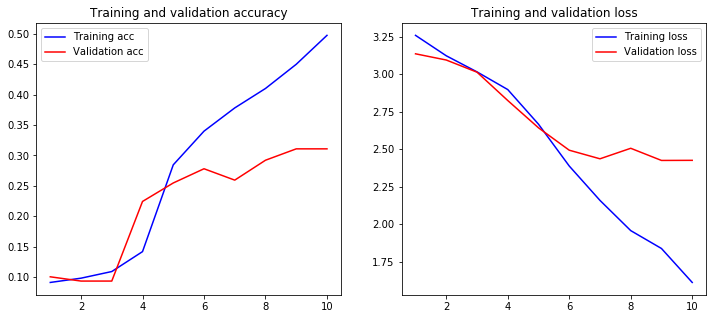

In [27]:
myfunc(turkishData,28,"turkish")

         Language        Label  \
45254  portuguese  advertising   
45255  portuguese  advertising   
45256  portuguese  advertising   
45257  portuguese  advertising   
45258  portuguese  advertising   

                                                    Text  
45254  Michel Temer (Deputado Federal) - 1986 Michel ...  
45255  Museu Nacional: a história do Brasil transform...  
45256  Imagem daquiAs casas fecham as pálpebras das j...  
45257  Quando a Propaganda Vence as Eleições Quando a...  
45258  Todo domingo a zebra do Fantástico anunciava o...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 100, 50)           2788150   
_________________________________________________________________
gru_22 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)     

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


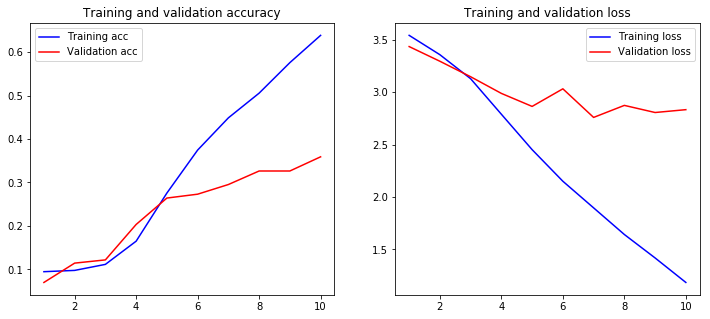

In [28]:
myfunc(portugueseData,37,"portuguese")

        Language          Label  \
42390  norwegian  entertainment   
42391  norwegian  entertainment   
42392  norwegian  entertainment   
42393  norwegian  entertainment   
42394  norwegian  entertainment   

                                                    Text  
42390  Flint wins 61st Annual CANUSA Games Jason Naso...  
42391  Jwalamukhi Movie Part 08/12 || Rajesh Hamal, V...  
42392  Oda Vige Helle 27/08/2018«Hvem bråker så mye o...  
42393  Asbjørn Slettemark Leave a commentEr den nye u...  
42394  Let’s livin’ it upYeah, one time forever mineF...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 100, 50)           1483550   
_________________________________________________________________
gru_23 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


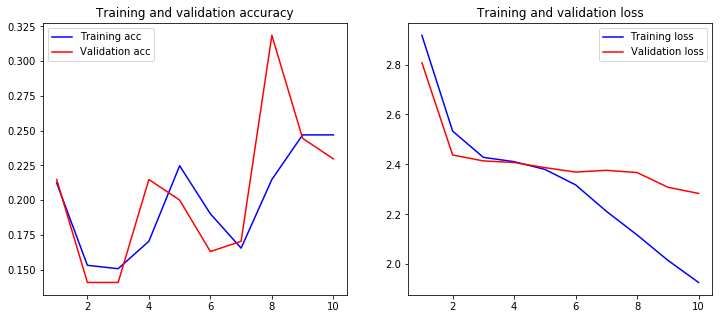

In [29]:
myfunc(norwegianData,19,"norwegian")

      Language          Label  \
18553  finnish    advertising   
18554  finnish    advertising   
18555  finnish    advertising   
18557  finnish  entertainment   
18558  finnish  entertainment   

                                                    Text  
18553  Fuckparade. Ehkä määrittävin hetki tämän vuode...  
18554  Berliini. Miten hieno on lauantai, jonka saa a...  
18555  View this post on InstagramFuckparade Lisää ku...  
18557  Annihilator ja D.O.A. perustajajäsen Randy Ram...  
18558  Lasten Hautausmaa jää luovalle tauolle tulevan...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 100, 50)           3174650   
_________________________________________________________________
gru_24 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_24 (Dropout)         (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


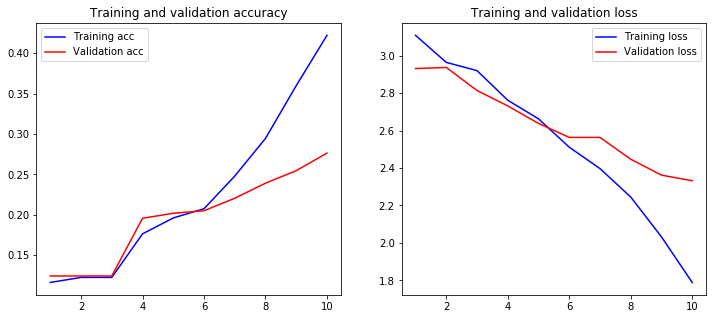

In [30]:
myfunc(finnishData,26,"finnish")

      Language          Label  \
4519  albanian  entertainment   
4520  albanian  entertainment   
4521  albanian  entertainment   
4522  albanian  entertainment   
4523  albanian  entertainment   

                                                   Text  
4519  Anton Marku Anton Marku u lind më 15 gusht 197...  
4520  Më kanë dalë mbi sipërfaqe Dhe shpirti buçet, ...  
4521  Sonata e Dritëhënës!Natë, pranverore. Dhomë e ...  
4522  Ted HUGHESKalendari poetik: Ted Hughes (1930-1...  
4523  të prek shpirtin e saj të brishtë, shpirtin e ...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 100, 50)           1519650   
_________________________________________________________________
gru_25 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0 

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


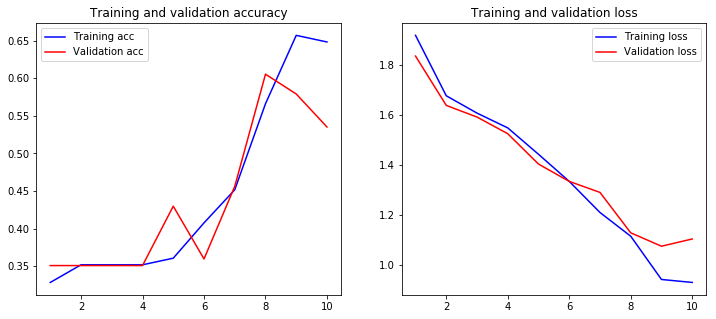

In [31]:
myfunc(albanianData,7,"albanian")

       Language          Label  \
17842  estonian  entertainment   
17843  estonian  entertainment   
17844  estonian  entertainment   
17845  estonian  entertainment   
17846  estonian  entertainment   

                                                    Text  
17842  JagaUus kooliaasta on kohe algamas ja seoses s...  
17843  Breakfast With The Beatles – August 19, 2018 M...  
17844  JagaAlles eelmise aasta lõpus esitletud Micros...  
17845  JagaTelerite heli võib küll olla üsna hea, kui...  
17846  JagaOn olemas erinevaid mobiilipakette, samuti...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 100, 50)           1442350   
_________________________________________________________________
gru_26 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)     

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


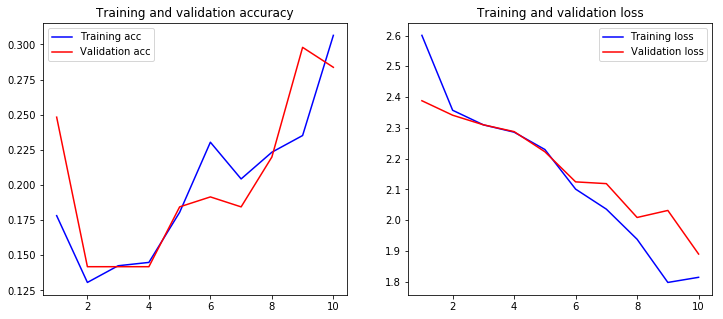

In [32]:
myfunc(estonianData,14,"estonian")

      Language        Label                                               Text
59630  swedish  advertising  18 augusti, 2018Moderaternas partiledare Ulf K...
59631  swedish  advertising  22 augusti, 2018Ylva Johansson (S), Ali Esbati...
59632  swedish  advertising  Jag förstår Vi sparar data i cookies , genom a...
59633  swedish  advertising  Politik Het valdebatt om lasGrus i maskineriet...
59634  swedish  advertising  5 september, 2018Christoffer Röstlund Jonsson ...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           2450650   
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               235776    
_________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


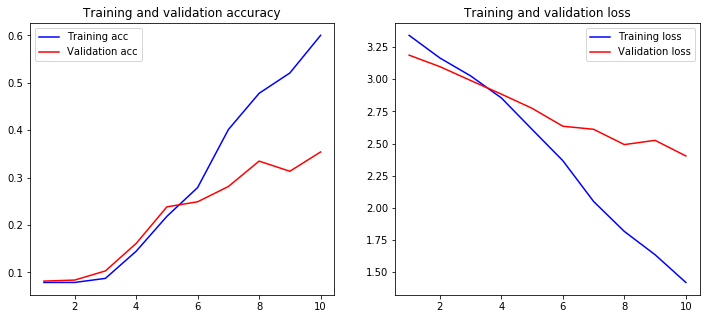

In [20]:
myfunc(swedishData,32,"swedish")

        Language                  Label  \
34142  icelandic                  games   
34143  icelandic                  games   
34144  icelandic                  games   
34145  icelandic                  games   
34149  icelandic  hobbies_and_interests   

                                                    Text  
34142  Keflavík vs Fylkir, Aug 31, 2018 – Preview, Wa...  
34143  Haukar vs IR Reykjavik, Sep 07,Icelandic Inkas...  
34144  Höttur vs Leiknir Fáskrúðsfjörður, Sep 08,Icel...  
34145  Fram vs HK Kópavogur, Sep 07,Icelandic Inkasso...  
34149  Keflavík vs Fylkir, Aug 31, 2018 – Preview, Wa...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 50)           368550    
_________________________________________________________________
gru_30 (GRU)                 (None, 256)               235776    
_________________________________________________________

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


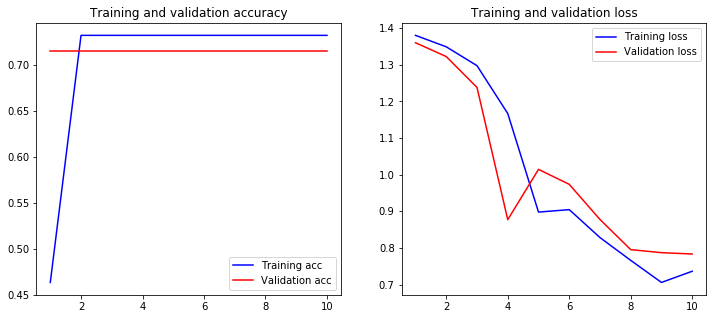

In [37]:
myfunc(icelandicData,4,"icelandic")

         Language          Label  \
41808  lithuanian  entertainment   
41809  lithuanian  entertainment   
41810  lithuanian  entertainment   
41811  lithuanian  entertainment   
41812  lithuanian  entertainment   

                                                    Text  
41808  Alan Fitzpatrick System Addicts Chart Tracklis...  
41809   Streamed live on Aug 20, 2018 Lietuvos social...  
41810   on Sep 5, 2018 Dalyvauja Lietuvos lenkų rinki...  
41811  Rating is available when the video has been re...  
41812   Streamed live on Sep 6, 2018 TS-LKD frakcijos...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 100, 50)           1404950   
_________________________________________________________________
gru_32 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_32 (Dropout)         (Non

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


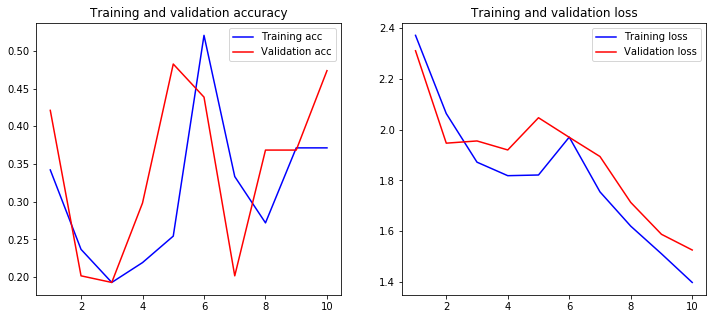

In [39]:
myfunc(lithuanianData,11,"lithuanian")

        Language          Label  \
64107  ukrainian  entertainment   
64108  ukrainian  entertainment   
64109  ukrainian  entertainment   
64110  ukrainian  entertainment   
64111  ukrainian  entertainment   

                                                    Text  
64107  Скарлетт Йоганссон очолила рейтинг Forbes 4 хв...  
64108  Xiaomi представила пралку за ₴ 5 711 3 хв 23 С...  
64109  LG V40 ThinQ матиме п’ять камер 3 хв 23 Сер, 2...  
64110  5G: скільки виробники смартфонів заплатять за ...  
64111  Джордж Клуні очолив рейтинг Forbes 3 хв 23 Сер...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 100, 50)           1827000   
_________________________________________________________________
gru_34 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_34 (Dropout)         (None, 256

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


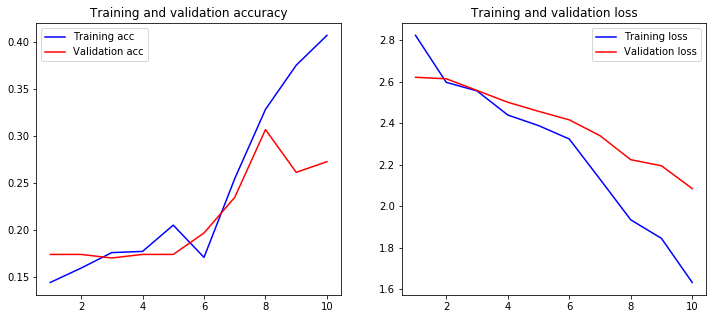

In [42]:
myfunc(ukrainianData,19,"ukrainian")

       Language            Label  \
38005  japanese  arts_and_crafts   
38006  japanese  arts_and_crafts   
38007  japanese  arts_and_crafts   
38008  japanese  arts_and_crafts   
38009  japanese  arts_and_crafts   

                                                    Text  
38005  午後7時から、びわ湖ホール大ホールで、下野竜也指揮NHK交響楽団の大津公演を聴く。N響の近畿...  
38006  観劇感想精選（252） オックスフォード・シェイクスピア・プレイヤーズ（オックスフォード大学...  
38007  アクラム・カーン振付「Chotto Desh/チョット・デッシュ」2018年8月12日 左京...  
38008  コンサートの記（416） 高関健指揮京都市交響楽団第626回定期演奏会 ブリテン 「戦争レク...  
38009  今日はKオケの練習日であるのだが、諸事情により楽器は持たず（会社に置きっぱなしのサイレントを...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 100, 50)           2765300   
_________________________________________________________________
gru_36 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_36 (Dropout)         (Non

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


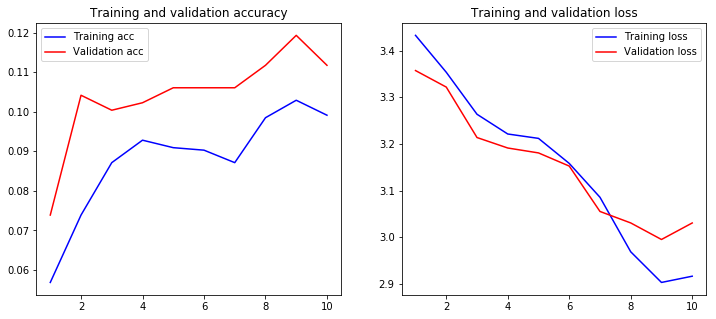

In [44]:
myfunc(japaneseData,34,"japanese")

        Language        Label  \
31407  hungarian  advertising   
31408  hungarian  advertising   
31409  hungarian  advertising   
31410  hungarian  advertising   
31411  hungarian  advertising   

                                                    Text  
31407  Az anyai örömök elé néző Szabó Kitti a sorozat...  
31408  Egyesült Államok – Az arc transzplantációjával...  
31409  Sztárvilág » Sztársztorik » Hazavitte kedvesét...  
31410  Hat hónapos szemhéj duzzanattal fordult orvosh...  
31411  Aktuális » Krimi » 11 éves kislányt zaklathato...  
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 100, 50)           4042350   
_________________________________________________________________
gru_38 (GRU)                 (None, 256)               235776    
_________________________________________________________________
dropout_38 (Dropout)         (None, 256)           

/home/nesma/anaconda3/envs/ImageProcessingLab/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


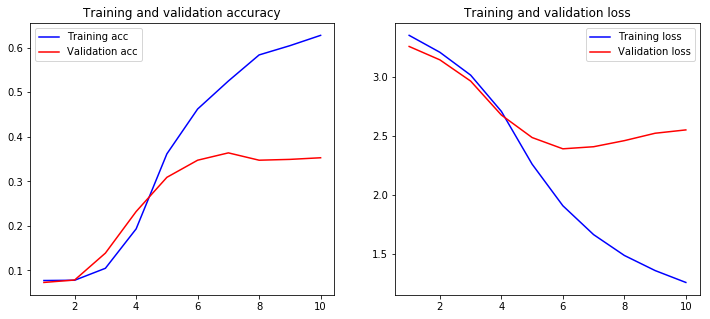

In [46]:
myfunc(hungarianData,31,"hungarian")

## PHASE II: Joint MultiLingual Classifier

#### English Testset Prepareation

In [9]:

# Get english testset

from keras.layers import GRU,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

myDataset = englishData
myDataset = Remove3Row(myDataset)

print(myDataset.head())
X = myDataset.Text
Y = myDataset.Label

encoder = LabelEncoder()
encoder.fit(Y)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1,stratify = Y)

EnglishValidationDS = pd.DataFrame(zip(Ytest,Xtest),columns=["Label","Text"])
EnglishValidationDS.to_csv("EnglishTestSet.csv",index = False)

  Language        Label                                               Text
0  english  advertising  Exclusive: U.S. government seeks Facebook help...
1  english  advertising  Trump asks SEC to mull half-year corporate fil...
2  english  advertising  Wall St. up on trade hopes, S&P equals longest...
3  english  advertising  Asian shares hit one-year low on Turkey, China...
4  english  advertising  Asian stocks weaken as Turkey worries weigh, d...


In [10]:
cond = dataset['Text'].isin(EnglishValidationDS['Text']) == True
dataset.drop(dataset[cond].index, inplace = True)
dataset.to_csv("AllExceptEnglishValidation.csv",index=None)

In [13]:
dataset.to_csv("AllExceptEnglishValidation.csv",index=None)

### classification Model with external testset 

In [82]:

from keras.layers import GRU,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer

import pandas as pd
import numpy as np
from keras.utils import np_utils

import matplotlib.pyplot as plt
 
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def Remove3Row(inputD):
    mydataset = inputD
    value_counts = mydataset['Label'].value_counts()

    # Select the values where the count is less than 3
    to_remove = value_counts[value_counts < 3].index

    # Keep rows where the city column is not in to_remove
    mydataset = mydataset[~mydataset.Label.isin(to_remove)]
    return mydataset



def myfuncTest(myDataset,shape,lang,testSet):
    myDataset = Remove3Row(myDataset)

    print(myDataset.head())
    X = myDataset.Text
    Y = myDataset.Label

    encoder = LabelEncoder()
    encoder.fit(Y)

    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1,stratify = Y)

#     Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=1,stratify = Ytrain)
    Xval = testSet.Text
    Yval = testSet.Label

    Ytrain = encoder.transform(Ytrain)
    Ytest = encoder.transform(Ytest)
    Yval = encoder.transform(Yval)

    Ytrain = np_utils.to_categorical(Ytrain)
    Ytest = np_utils.to_categorical(Ytest)
    Yval = np_utils.to_categorical(Yval)


    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(Xtrain)

    Xtrain = tokenizer.texts_to_sequences(Xtrain)
    Xtest = tokenizer.texts_to_sequences(Xtest)
    Xval = tokenizer.texts_to_sequences(Xval)
    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

    maxlen = 100

    Xtrain = pad_sequences(Xtrain, padding='post', maxlen=maxlen)
    Xtest = pad_sequences(Xtest, padding='post', maxlen=maxlen)
    Xval = pad_sequences(Xval, padding='post', maxlen=maxlen)


    from keras.models import Sequential
    from keras import layers

    embedding_dim = 50

    model = Sequential()
    model.add(layers.Embedding(input_dim=vocab_size, 
                               output_dim=embedding_dim, 
                               input_length=maxlen))


    model.add(GRU(256))
    model.add(Dropout(0.1))
    model.add(layers.Dense(shape, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()

    history = model.fit(Xtrain, Ytrain,
                        epochs=10,
                        verbose=True,
                        validation_data=(Xval, Yval))
    f= open("report.csv","a")
    loss, accuracy = model.evaluate(Xtrain, Ytrain, verbose=True)
    print("Training Accuracy: {:.4f}".format(accuracy))
    f.write(lang+",{:.4f}".format(accuracy))

    loss, accuracy = model.evaluate(Xval, Yval, verbose=True)
   
    print("Validation Accuracy:  {:.4f}".format(accuracy))
    f.write(",{:.4f} \n".format(accuracy))
    f.close()
    plot_history(history)
    Ypred = model.predict(Xtest)
    from sklearn.metrics import confusion_matrix, classification_report

    matrix = confusion_matrix(Ytest.argmax(axis=1), Ypred.argmax(axis=1))
    classification_Report = classification_report(Ytest.argmax(axis=1), Ypred.argmax(axis=1), output_dict=True)
    df = pd.DataFrame(classification_Report).transpose()
    df.to_csv(lang+"ClassificationReport.csv")



### Multilingual Model, To be Run over the Server

In [17]:
# Multilingual joint
EnglishValidationDS = pd.read_csv("EnglishTestSet.csv")
dataset =  pd.read_csv("AllExceptEnglishValidation.csv")
myfuncTest(dataset,45,"Joint",EnglishValidationDS)


## PHASEIII:  Translation 

### Remove English Validation from Translation Dataset 

In [40]:
EnglishValidationDS = pd.read_csv("EnglishTestSet.csv")
Tdataset =  pd.read_csv("Translation.csv")
len(Tdataset)

35348

In [39]:
englishData = englishData.drop(columns="Language")

In [51]:
Tdataset = Tdataset.append(englishData)

In [53]:
cond = Tdataset['Text'].isin(EnglishValidationDS['Text']) == True
Tdataset.drop(Tdataset[cond].index, inplace = True)
Tdataset.to_csv("TranslationExceptEnglishTest.csv",index=None)

In [26]:
EnglishValidationDS.head()

,Label,Text
0,travel,"14, 2018“WHAT is the city but the people?” Th..."
1,adult,Elsevier Summary: Over the past 50 years resea...
2,dating,"I was a lot younger then I was back then, most..."
3,comic_books,"By creating an account, you verify that you ar..."
4,marketing,By Aileen Kwun 2 minute ReadAlphabet’s Sidewal...


### Translation Model, To be Run over the Server, Using English TestSet

In [ ]:
EnglishValidationDS = pd.read_csv("EnglishTestSet.csv")
dataset =  pd.read_csv("TranslationExceptEnglishTest.csv")
myfuncTest(dataset,45,"TranslationEngTest",EnglishValidationDS)

### Translation Using 20 %

In [56]:
Tdataset =  pd.read_csv("Translation.csv")

In [57]:
Tdataset = Tdataset.append(englishData)

In [58]:
Tdataset.to_csv("TranslationAllLanguages.csv",index=None)

### Translation Model, To be Run over the Server, Using 20% Testset

In [ ]:
dataset = pd.read_csv('TranslationAllLanguages.csv')
myfunc(dataset,45,"TranslationAll20p")

## PHASE IIII Round Trip

In [106]:
print(len(englishData))
englishData = englishData.drop(columns="Language")


4519


In [107]:
len(EnglishValidationDS)

904

In [108]:
cond = englishData['Text'].isin(EnglishValidationDS['Text']) == True
englishData.drop(englishData[cond].index, inplace = True)


3288

In [110]:
englishData.to_csv("EnglishDataTrainingPartPreparedforRounTrip.csv")

### We Used IBM to translate this dataset to Germany and to english back

#### This code to be run on the server

In [ ]:
EnglishValidationDS = pd.read_csv("EnglishTestSet.csv")
dataset =  pd.read_csv("RoundTripDS.csv")
myfuncTest(dataset,45,"RoundTrip",EnglishValidationDS)